In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from skimage import io

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.applications import VGG19

from warnings import filterwarnings
filterwarnings('ignore')

import random

import glob
from IPython.display import display

# Explanation:
***
* **os:** Operating system dependent functionality.
* **numpy:** Numerical computing library for handling arrays and matrices.
* **pandas:** Data manipulation and analysis library.
* **matplotlib.pyplot:** Library for creating visualizations in Python.
* **seaborn:** Data visualization library based on matplotlib.
* **cv2:** OpenCV library for computer vision tasks.
* **skimage.io:** Module from scikit-image for image input and output.
* **train_test_split:** Helper function from scikit-learn for splitting data into training and testing sets.
* **tensorflow:** Machine learning framework developed by Google.
* **Sequential:** Keras API for creating sequential models layer-by-layer.
* **layers:** Module from Keras providing various types of layers for building neural networks.
* **optimizers:** Module from Keras providing optimization algorithms.
* **Model:** Keras API for defining complex models with multiple inputs and outputs.
* **load_model:** Function for loading a pre-trained Keras model.
* **glorot_uniform:** Glorot uniform initializer for initializing layer weights.
* **plot_model:** Function for creating a plot of the neural network model.
* **ReduceLROnPlateau:** Callback to reduce learning rate when a metric has stopped improving.
* **EarlyStopping:** Callback to stop training when a monitored metric has stopped improving.
* **ModelCheckpoint:** Callback to save the model after every epoch.
* **LearningRateScheduler:** Callback to schedule the learning rate.
* **K:** Keras backend module for low-level operations.
* **Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input:** Different types of layers used in neural networks.
* **VGG19:** Pre-trained deep learning model for image recognition.
* **filterwarnings:** Function to control display of warnings.
* **random:** Module for generating pseudo-random numbers.
* **glob:** Module for finding all pathnames matching a specified pattern according to the rules used by the Unix shell.
* **IPython.display:** Module for displaying rich media representations in IPython.

In [2]:
data = pd.read_csv('input/lgg-mri-segmentation/kaggle_3m/data.csv')
data_map = []
for sub_dir_path in glob.glob("input/lgg-mri-segmentation/kaggle_3m/"+"*"):
    #if os.path.isdir(sub_path_dir):
    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + '/' + filename
            data_map.extend([dir_name, image_path])
    except Exception as e:
        print(e)

df = pd.DataFrame({"patient_id" : data_map[::2],"path" : data_map[1::2]})
df_imgs = df[~df['path'].str.contains("mask")] # if have not mask
df_masks = df[df['path'].str.contains("mask")]# if have mask

df_imgs = df[~df['path'].str.contains("mask")] # if have not mask
df_masks = df[df['path'].str.contains("mask")]# if have mask

[WinError 267] The directory name is invalid: 'input/lgg-mri-segmentation/kaggle_3m\\data.csv'
[WinError 267] The directory name is invalid: 'input/lgg-mri-segmentation/kaggle_3m\\README.md'


# Explanation
***
Iterates through directories and files inside the specified path, extracting directory names and corresponding image file paths. It creates a list `data_map` where even-indexed elements are directory names, and odd-indexed elements are image file paths.

Then Creates two DataFrames, `df_imgs` and `df_masks`, by filtering rows based on whether the 'mask' string is present in the 'path' column.`df_imgs` contains rows without 'mask', and `df_mask`s contains rows with 'mask'.

In [3]:
# File path line length images for later sorting
BASE_LEN = 89 # len(input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_ <-!!!43.tif)
END_IMG_LEN = 4 # len(input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->.tif)
END_MASK_LEN = 9 # (input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->_mask.tif)

# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x: x[BASE_LEN:-END_IMG_LEN])
masks = sorted(df_masks["path"].values, key=lambda x: x[BASE_LEN:-END_MASK_LEN])

# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

# Final dataframe
brain_df = pd.DataFrame({"patient_id": df_imgs.patient_id.values,
                         "image_path": imgs,
                         "mask_path": masks
                        })
def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : 
        return 1
    else:
        return 0
    
brain_df['mask'] = brain_df['mask_path'].apply(lambda x: pos_neg_diagnosis(x))
brain_df


Path to the Image: input/lgg-mri-segmentation/kaggle_3m\TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_11.tif 
Path to the Mask: input/lgg-mri-segmentation/kaggle_3m\TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_12_mask.tif


patient_id  \
0     kaggle_3m\TCGA_CS_4941_19960909   
1     kaggle_3m\TCGA_CS_4941_19960909   
2     kaggle_3m\TCGA_CS_4941_19960909   
3     kaggle_3m\TCGA_CS_4941_19960909   
4     kaggle_3m\TCGA_CS_4941_19960909   
...                               ...   
3924  kaggle_3m\TCGA_HT_A61B_19991127   
3925  kaggle_3m\TCGA_HT_A61B_19991127   
3926  kaggle_3m\TCGA_HT_A61B_19991127   
3927  kaggle_3m\TCGA_HT_A61B_19991127   
3928  kaggle_3m\TCGA_HT_A61B_19991127   

                                             image_path  \
0     input/lgg-mri-segmentation/kaggle_3m\TCGA_CS_4...   
1     input/lgg-mri-segmentation/kaggle_3m\TCGA_CS_4...   
2     input/lgg-mri-segmentation/kaggle_3m\TCGA_CS_4...   
3     input/lgg-mri-segmentation/kaggle_3m\TCGA_CS_4...   
4     input/lgg-mri-segmentation/kaggle_3m\TCGA_CS_4...   
...                                                 ...   
3924  input/lgg-mri-segmentation/kaggle_3m\TCGA_HT_A...   
3925  input/lgg-mri-segmentation/kaggle_3m\TCGA_HT_A...   
3926  input/lgg-mri-segmentation/kaggle_3m\TCGA_HT_A...   
3927  input/lgg-mri-segmentation/kaggle_3m\TCGA_HT_A...   
3928  input/lgg-mri-segmentation/kaggle_3m\TCGA_HT_A...   

                                              mask_path  mask  
0     input/lgg-mri-segmentation/kaggle_3m\TCGA_CS_4...     0  
1     input/lgg-mri-segmentation/kaggle_3m\TCGA_CS_4...     1  
2     input/lgg-mri-segmentation/kaggle_3m\TCGA_CS_4...     1  
3     input/lgg-mri-segmentation/kaggle_3m\TCGA_CS_4...     1  
4     input/lgg-mri-segmentation/kaggle_3m\TCGA_CS_4...     1  
...                                                 ...   ...  
3924  input/lgg-mri-segmentation/kaggle_3m\TCGA_HT_A...     0  
3925  input/lgg-mri-segmentation/kaggle_3m\TCGA_HT_A...     0  
3926  input/lgg-mri-segmentation/kaggle_3m\TCGA_HT_A...     0  
3927  input/lgg-mri-segmentation/kaggle_3m\TCGA_HT_A...     0  
3928  input/lgg-mri-segmentation/kaggle_3m\TCGA_HT_A...     0  

[3929 rows x 4 columns]

# Explanation:
***
The `imgs` and `masks` lists are sorted based on the numerical values extracted from the file paths. The sorting is done using the integers obtained by slicing the paths using the defined constants.

Then Creates a DataFrame `brain_df` containing columns for patient IDs, image paths, and mask paths.

Then Defines a function `pos_neg_diagnosis` that checks if a mask contains positive (non-zero) values. It returns 1 for positive masks and 0 for negative masks.
Applies the `pos_neg_diagnosis` function to the 'mask_path' column of the DataFrame and creates a new column 'mask' with binary labels (1 for positive, 0 for negative).


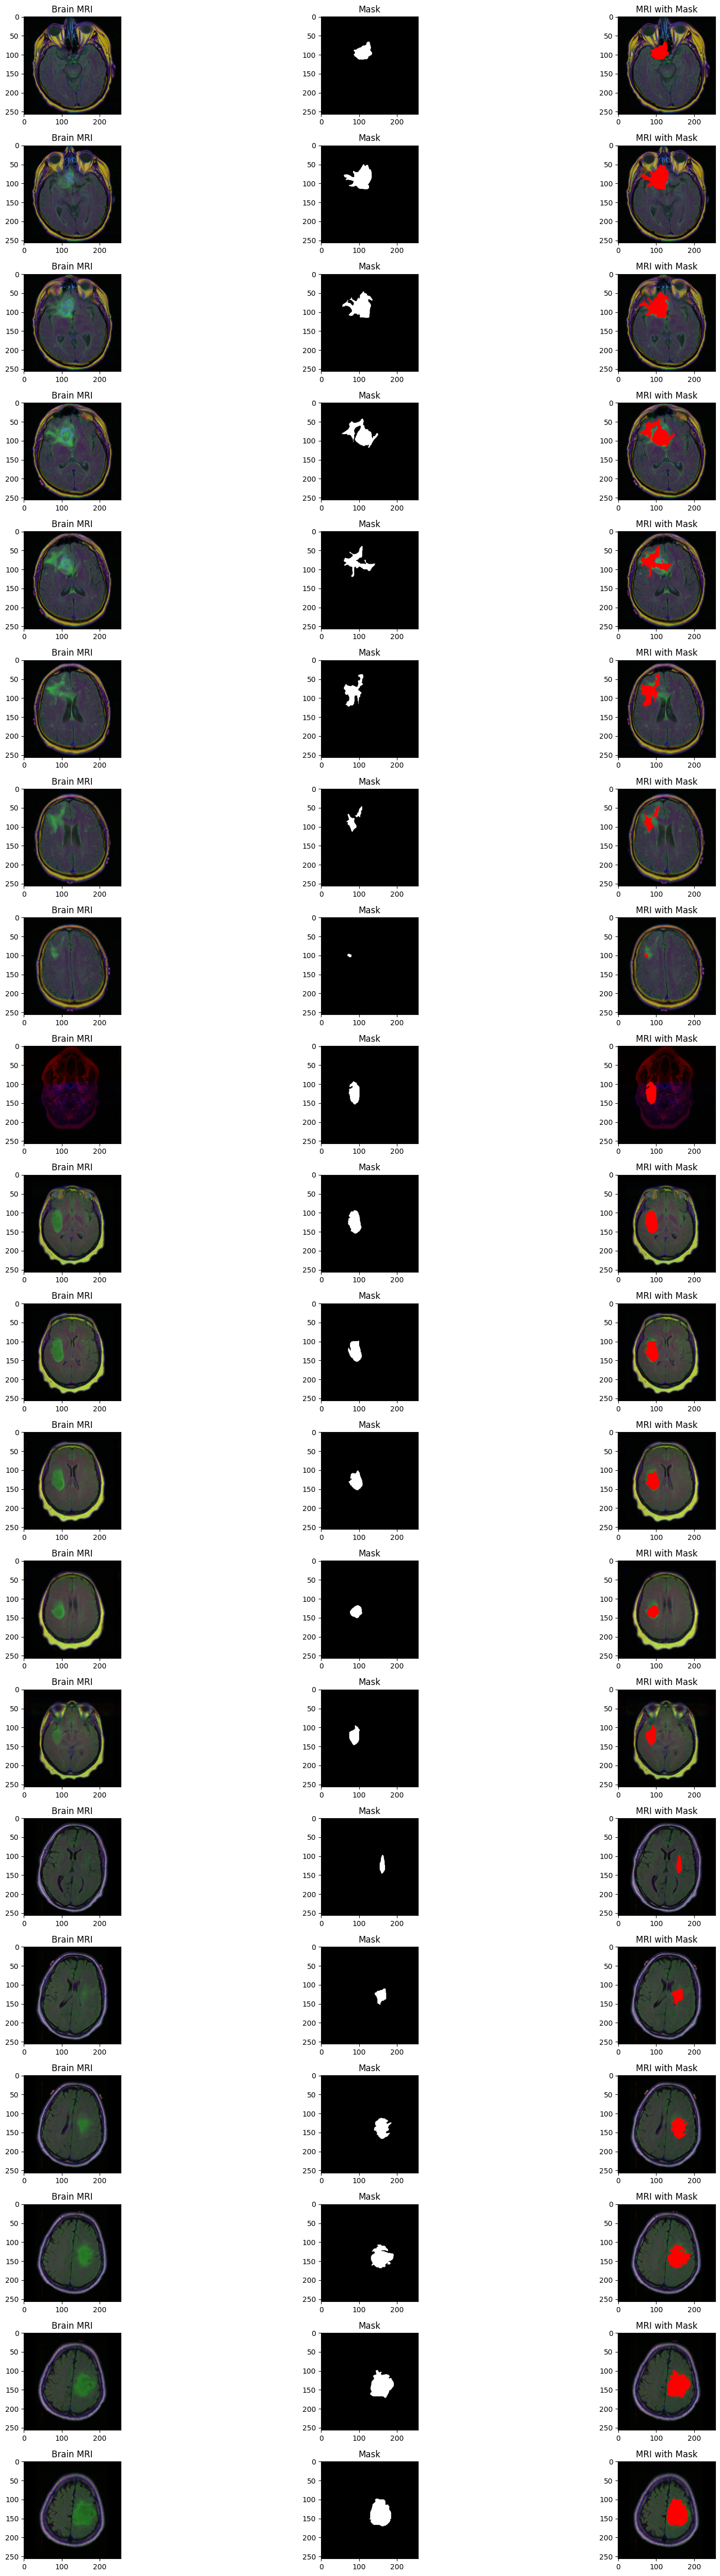

In [4]:
brain_df['mask'].value_counts()

count = 0
i = 0
fig,axs = plt.subplots(20,3, figsize=(20,50))
for mask in brain_df['mask']:
    if (mask==1):
        img = io.imread(brain_df.image_path[i])
        axs[count][0].title.set_text("Brain MRI")
        axs[count][0].imshow(img)
        
        mask = io.imread(brain_df.mask_path[i])
        axs[count][1].title.set_text("Mask")
        axs[count][1].imshow(mask, cmap='gray')
        
        img[mask==255] = (255,0,0)  # change pixel color at the position of mask
        axs[count][2].title.set_text("MRI with Mask")
        axs[count][2].imshow(img)
        count +=1
    i += 1
    if (count==20):
        break
        
fig.tight_layout()

# Explanation:
***
Above code creates a visualization for a subset of the data in the `brain_df` DataFrame. It selects images and masks where the mask contains positive values (1) and then plots the original brain MRI image, the mask, and the MRI image with the mask overlaid in red.

Iterates through the rows of the `brain_df` DataFrame. If the mask value is 1 (indicating a positive mask), it loads the corresponding brain MRI image and mask. It then creates subplots for the brain MRI, the mask, and the MRI with the mask overlaid in red. The loop continues until 20 images with positive masks have been displayed.

In [5]:
brain_df_train = brain_df.drop(columns=['patient_id'])
# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))
brain_df_train.info()

brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


(1373, 4)

# Explanation:
***
This code prepares the `brain_df` DataFrame for training by dropping the 'patient_id' column, converting the 'mask' column values to strings, and then examines the filtered DataFrame to understand the distribution of positive masks in the dataset.


In [6]:
# creating test, train and val sets
X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)
print("Train size is {}, valid size is {} & test size is {}".format(len(X_train), len(X_val), len(X_test)))

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

Train size is 1167, valid size is 103 & test size is 103


# Explanation:
***

* `X_train:` Contains a portion of the data (85%) for training the model.
* `X_val:` Contains a smaller portion (7.5%) for validation during training.
* `X_test:` Contains the remaining portion (7.5%) for testing the trained model.
The `train_test_split` function from scikit-learn is used twice to split the data into validation and test sets from the original `brain_df_mask` DataFrame.

In [7]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, ids , mask, image_dir = './', batch_size = 16, img_h = 256, img_w = 256, shuffle = True):

    self.ids = ids
    self.mask = mask
    self.image_dir = image_dir
    self.batch_size = batch_size
    self.img_h = img_h
    self.img_w = img_w
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    'Get the number of batches per epoch'

    return int(np.floor(len(self.ids)) / self.batch_size)

  def __getitem__(self, index):
    'Generate a batch of data'

    #generate index of batch_size length
    indexes = self.indexes[index* self.batch_size : (index+1) * self.batch_size]

    #get the ImageId corresponding to the indexes created above based on batch size
    list_ids = [self.ids[i] for i in indexes]

    #get the MaskId corresponding to the indexes created above based on batch size
    list_mask = [self.mask[i] for i in indexes]


    #generate data for the X(features) and y(label)
    X, y = self.__data_generation(list_ids, list_mask)

    #returning the data
    return X, y

  def on_epoch_end(self):
    'Used for updating the indices after each epoch, once at the beginning as well as at the end of each epoch'
    
    #getting the array of indices based on the input dataframe
    self.indexes = np.arange(len(self.ids))

    #if shuffle is true, shuffle the indices
    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_ids, list_mask):
    'generate the data corresponding the indexes in a given batch of images'

    # create empty arrays of shape (batch_size,height,width,depth) 
    #Depth is 3 for input and depth is taken as 1 for output becasue mask consist only of 1 channel.
    X = np.empty((self.batch_size, self.img_h, self.img_w, 3))
    y = np.empty((self.batch_size, self.img_h, self.img_w, 1))

    #iterate through the dataframe rows, whose size is equal to the batch_size
    for i in range(len(list_ids)):
      #path of the image
      img_path = str(list_ids[i])
      
      #mask path
      mask_path = str(list_mask[i])
      
      #reading the original image and the corresponding mask image
      img = io.imread(img_path)
      mask = io.imread(mask_path)

      #resizing and coverting them to array of type float64
      img = cv2.resize(img,(self.img_h,self.img_w))
      img = np.array(img, dtype = np.float64)
      
      mask = cv2.resize(mask,(self.img_h,self.img_w))
      mask = np.array(mask, dtype = np.float64)

      #standardising 
      img -= img.mean()
      img /= img.std()
      
      mask -= mask.mean()
      mask /= mask.std()
      
      #Adding image to the empty array
      X[i,] = img
      
      #expanding the dimnesion of the image from (256,256) to (256,256,1)
      y[i,] = np.expand_dims(mask, axis = 2)
    
    #normalizing y
    y = (y > 0).astype(int)

    return X, y

train_data = DataGenerator(train_ids, train_mask)
val_data = DataGenerator(val_ids, val_mask)

# Explanation:
***
1. **Initialization of DataGenerator:**
   1. `ids:` List of image file pathss.
   2. `mask:` List of mask file paths.
   3. `image_dir:` Directory where image and mask files are located.
   4. `batch_size:` Number of samples in each batch.
   5. `img_h:` Height of the resized images.
   6. `img_w:` Width of the resized images.
   7. `shuffle:` Whether to shuffle the data at the end of each epoch.
2. **Length Calculation:**
   1. `__len__` method calculates the number of batches per epoch based on the total number of data samples and the batch size. It returns the integer value of the floor division.
3. **Data Retrieval:**
   1. `__getitem__` method generates a batch of data. It retrieves the indexes of the data samples for the current batch and then gets the corresponding image and mask paths.
   2. It calls the `__data_generation` method to load and preprocess the data for this batch.
   3. It returns the X (features) and y (labels) for the batch.
4. **Shuffling Data:**
   1. `on_epoch_end` method is used for updating the indices after each epoch. If `shuffle` is `True`, it shuffles the indices, ensuring different data order in each epoch.
5. **Data Generation and Preprocessing:**
   1. `__data_generation` method generates the data corresponding to the indexes in a given batch.
   2. It initializes empty arrays for X and y with the appropriate shape.
   3. For each sample in the batch, it reads the original image and mask, resizes them, standardizes them, and adds them to the X and y arrays.
   4. The mask is also thresholded (binarized) to contain values 0 or 1.
6. **Data Generator Instances:**
   1. `train_data` and `val_data` are instances of the `DataGenerator` class created for the training and validation sets, respectively. These instances will be used to load and preprocess data in batches during model training and validation.training and validation.
ining and validation.
raining and validation.

In [8]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet_vgg19(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained VGG19 Model """
    vgg19 = VGG19(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = vgg19.get_layer("block1_conv2").output         
    s2 = vgg19.get_layer("block2_conv2").output         
    s3 = vgg19.get_layer("block3_conv4").output         
    s4 = vgg19.get_layer("block4_conv4").output         

    """ Bridge """
    b1 = vgg19.get_layer("block5_conv4").output         

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     
    d2 = decoder_block(d1, s3, 256)                     
    d3 = decoder_block(d2, s2, 128)                    
    d4 = decoder_block(d3, s1, 64)                      

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="VGG19_U-Net")
    return model
model = build_unet_vgg19((256,256,3))
model.summary()

Model: "VGG19_U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 256, 256, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)         0         ['block1_conv2[0][0]']        
                                                                                        

# Explanation:
***
Above Code defines a U-Net architecture based on the VGG19 model for image segmentation. Here's what each part of the code does:

1. **Convolutional Block:**
   1. The `conv_block` function defines a basic convolutional block with two convolutional layers, batch normalization, and ReLU activation.
2. **Decoder Block:**
   1. The `decoder_block` function defines a decoder block that performs upsampling (using `Conv2DTranspose`), concatenation with skip connections from the encoder, and then applies the convolutional block defined by `conv_block`.
3. **U-Net Architecture with VGG19 Backbone:**
   1. The 'build_unet_vgg19`function constructs the U-Net architecture using the VGG19 model as the encoder backbone.
   2. The VGG19 model layers are extracted until specific layers (`block1_conv2`, `block2_conv2`, `block3_conv4`, `block4_conv4`, and `block5_conv4`) which act as skip connections.
   3. The bridge is formed by the last layer of the VGG19 model (`block5_conv4`).
   4. Decoder blocks are used to upsample and concatenate the skip connections in reverse order.
   5. The final output layer consists of a convolutional layer with a sigmoid activation function, producing a binary mask for segmentation.
4. **Model Compilation:**
   1. The model is compiled after construction.
5. **Model Summary:**
   1. `model.summary()` prints the summary of the constructed U-Net VGG19-based model, showing the layers, output shapes, and the number of parameters.

In [9]:
# custom loss function for UNet Vgg19 model

epsilon = 1e-5
smooth = 1

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

# compling model and callbacks functions
adam = tf.keras.optimizers.Adam(learning_rate = 0.05, epsilon = 0.1)
model.compile(optimizer = adam, 
                  loss = focal_tversky, 
                  metrics = [tversky]
                 )
#callbacks
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min', 
                              verbose=1, 
                              patience=30
                             )
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="segmentation_model.h5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )

# Explanation:
***
Above code defines custom loss functions and sets up the compilation and callback functions for the U-Net VGG19 model. Here's what each part of the code does:

1. **Custom Loss Functions:**
   * `Tversky Index:` The `tversky` function calculates the Tversky index, a measure of similarity between two sets, using the true positive, false negative, and false positive values. It incorporates a balancing factor `alpha` to control the trade-off between false positives and false negatives.
   * `Focal Tversky Loss:` The `focal_tversky` function computes the focal Tversky loss, which is a modified version of the Tversky index with a focal loss component. It introduces a focusing parameter `gamma` to down-weight easy examples and focus more on hard examples during training.
   * `Tversky Loss:` The `tversky_loss` function calculates the Tversky loss, which is simply `1 - tversky`. This loss function is used during training to minimize the dissimilarity between the predicted masks and the ground truth masks.
2. **Compiling the Model:**
   * The model is compiled using the Adam optimizer with a specified learning rate and epsilon value.
   * The loss function is set to `focal_tversky`, and the metric for evaluation is `tversky`.
3. **Callbacks:**
   * `Early Stopping:` The `EarlyStopping` callback monitors the validation loss and stops training when the loss stops decreasing, with patience set to 30 epochs.
   * `Model Checkpoint:` The `ModelCheckpoint` callback saves the best model based on validation loss during training. The saved model is named "segmentation_model.h5".
   * `Reduce Learning Rate on Plateau:` The `ReduceLROnPlateau` callback reduces the learning rate when the validation loss plateaus, with a patience of 10 epochs, a minimum delta of 0.0001, and a reduction factor of 0.2.

In [10]:
history = model.fit(train_data, 
                  epochs = 10, 
                  validation_data = val_data,
                  callbacks = [checkpointer, earlystopping, reduce_lr])

Epoch 1/10
72/72 [==============================] - ETA: 0s - loss: 0.7849 - tversky: 0.2743 
Epoch 1: val_loss improved from inf to 0.82669, saving model to segmentation_model.h5
72/72 [==============================] - 3466s 48s/step - loss: 0.7849 - tversky: 0.2743 - val_loss: 0.8267 - val_tversky: 0.2237 - lr: 0.0500
Epoch 2/10
72/72 [==============================] - ETA: 0s - loss: 0.6080 - tversky: 0.4831 
Epoch 2: val_loss improved from 0.82669 to 0.82626, saving model to segmentation_model.h5
72/72 [==============================] - 3538s 49s/step - loss: 0.6080 - tversky: 0.4831 - val_loss: 0.8263 - val_tversky: 0.2235 - lr: 0.0500
Epoch 3/10
72/72 [==============================] - ETA: 0s - loss: 0.5735 - tversky: 0.5215 
Epoch 3: val_loss did not improve from 0.82626
72/72 [==============================] - 3417s 47s/step - loss: 0.5735 - tversky: 0.5215 - val_loss: 0.8694 - val_tversky: 0.1699 - lr: 0.0500
Epoch 4/10
72/72 [==============================] - ETA: 0s - loss

# Explanation:
***
This line of code trains the model for 10 epochs using the training data (`train_data`). The validation data (`val_data`) is used for validation during training. The `callbacks` parameter specifies the list of callbacks to apply during training. In this case, the model checkpoint, early stopping, and reduce learning rate on plateau callbacks are used.
   * `epochs:` The number of epochs (iterations over the entire dataset) for training the model.
   * `validation_data:` Data to be used for validation during training.
   * `callbacks:` List of callbacks to apply during training. Here, checkpointer saves the best model, earlystopping stops training when the validation loss stops decreasing, and reduce_lr reduces the learning rate when the validation loss plateaus.

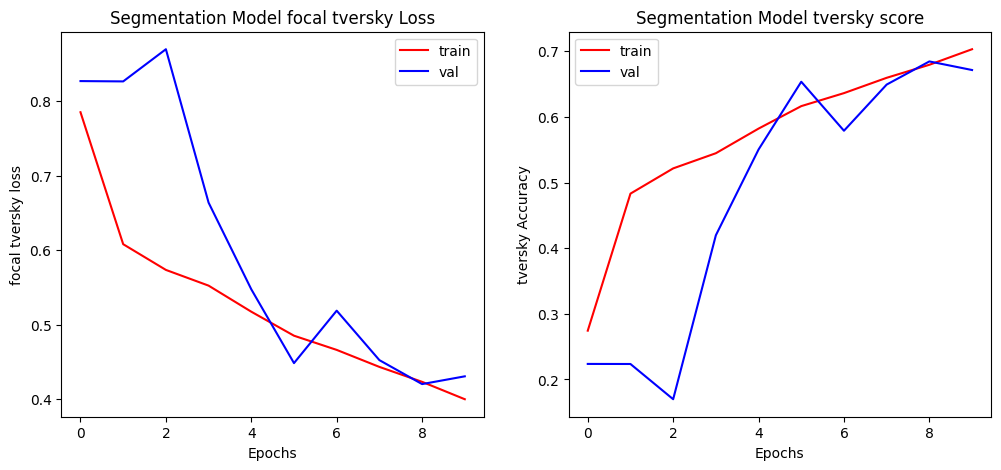

In [11]:
model = load_model("segmentation_model.h5",custom_objects={"focal_tversky":focal_tversky,"tversky":tversky,"tversky_loss":tversky_loss})

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'r');
plt.plot(history.history['val_loss'], 'b');
plt.title("Segmentation Model focal tversky Loss");
plt.ylabel("focal tversky loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(history.history['tversky'], 'r');
plt.plot(history.history['val_tversky'], 'b');
plt.title("Segmentation Model tversky score");
plt.ylabel("tversky Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

# Explanation:
***
   * `Left Plot:` This subplot shows the training loss (in red) and the validation loss (in blue) over epochs. It helps visualize how well the model is learning from the training data and how well it generalizes to unseen data during validation.
   * `Right Plot:` This subplot displays the training Tversky score (in red) and the validation Tversky score (in blue) over epochs. The Tversky score measures the similarity between the predicted masks and the ground truth masks. Higher Tversky score indicates better segmentation accu.raccy.y.
cy.

In [12]:
test_ids = list(X_test.image_path)
test_mask = list(X_test.mask_path)

def prediction(test, model_seg):
  
    # empty list to store results
    mask, image_id,has_mask = [], [], []
    
    #itetrating through each image in test data
    for i in test.image_path:
        

        
        #Creating a empty array of shape 1,256,256,1
        X = np.empty((1,256,256,3))
        # read the image
        img = io.imread(i)
        #resizing the image and coverting them to array of type float64
        img = cv2.resize(img, (256,256))
        img = np.array(img, dtype=np.float64)
        
        # standardising the image
        img -= img.mean()
        img /= img.std()
        #converting the shape of image from 256,256,3 to 1,256,256,3
        X[0,] = img
        
        #make prediction of mask
        predict = model_seg.predict(X)
        
        # if sum of predicted mask is 0 then there is not tumour
        if predict.round().astype(int).sum()==0:
            image_id.append(i)
            has_mask.append(0)
            mask.append('No mask :)')
        else:
        #if the sum of pixel values are more than 0, then there is tumour
            image_id.append(i)
            has_mask.append(1)
            mask.append(predict)
            
    return pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})


# Explanation:
***
Above code defines a function called `prediction` that takes a test dataset and a trained segmentation model as input and predicts masks for the images in the test dataset. Here's a breakdown of what the function does:

1. **Input Parameters:**
   * `test:` Test dataset containing image file paths.
   * `model_seg:` Trained segmentation model (U-Net VGG19) used for prediction.
2. **Prediction Process:**
   * The function iterates through each image path in the test dataset.
   * For each image, it creates an empty array X of shape (1, 256, 256, 3).
   * It reads the image, resizes it to (256, 256), standardizes the pixel values, and assigns it to the first element of the `X` array.
   * The model `model_seg` predicts the mask for the current image using the `predict` function.
   * If the sum of the predicted mask pixel values is 0, indicating no tumor, the image path, predicted mask, and `has_mask` value (set to 0) are appended to the respective lists.
   * If the sum of pixel values is greater than 0, indicating the presence of a tumor, the image path, predicted mask, and `has_mask` value (set to 1) are appended to the lists.
   * The function returns a Pandas DataFrame containing image paths, predicted masks (or 'No mask :)' if no tumor), and binary has_mask values.
The function essentially predicts whether a tumor is present in each image and provides the corresponding predicted masks or indicates the absence of a tumor. It encapsulates the prediction process for the given segmentation model and test dataset.

In [13]:
# making prediction
df_pred = prediction(X_test, model)
df_pred

# merging original and prediction df
df_pred = X_test.merge(df_pred, on='image_path')
df_pred.head(10)

1/1 [==============================] - 1s 1s/step


patient_id  \
0  kaggle_3m\TCGA_DU_A5TT_19980318   
1  kaggle_3m\TCGA_HT_7882_19970125   
2  kaggle_3m\TCGA_CS_6665_20010817   
3  kaggle_3m\TCGA_FG_5962_20000626   
4  kaggle_3m\TCGA_HT_A616_19991226   
5  kaggle_3m\TCGA_HT_7684_19950816   
6  kaggle_3m\TCGA_DU_5854_19951104   
7  kaggle_3m\TCGA_DU_8166_19970322   
8  kaggle_3m\TCGA_HT_7616_19940813   
9  kaggle_3m\TCGA_HT_7884_19980913   

                                          image_path  \
0  input/lgg-mri-segmentation/kaggle_3m\TCGA_DU_A...   
1  input/lgg-mri-segmentation/kaggle_3m\TCGA_HT_7...   
2  input/lgg-mri-segmentation/kaggle_3m\TCGA_CS_6...   
3  input/lgg-mri-segmentation/kaggle_3m\TCGA_FG_5...   
4  input/lgg-mri-segmentation/kaggle_3m\TCGA_HT_A...   
5  input/lgg-mri-segmentation/kaggle_3m\TCGA_HT_7...   
6  input/lgg-mri-segmentation/kaggle_3m\TCGA_DU_5...   
7  input/lgg-mri-segmentation/kaggle_3m\TCGA_DU_8...   
8  input/lgg-mri-segmentation/kaggle_3m\TCGA_HT_7...   
9  input/lgg-mri-segmentation/kaggle_3m\TCGA_HT_7...   

                                           mask_path  mask  \
0  input/lgg-mri-segmentation/kaggle_3m\TCGA_DU_A...     1   
1  input/lgg-mri-segmentation/kaggle_3m\TCGA_HT_7...     1   
2  input/lgg-mri-segmentation/kaggle_3m\TCGA_CS_6...     1   
3  input/lgg-mri-segmentation/kaggle_3m\TCGA_FG_5...     1   
4  input/lgg-mri-segmentation/kaggle_3m\TCGA_HT_A...     1   
5  input/lgg-mri-segmentation/kaggle_3m\TCGA_HT_7...     1   
6  input/lgg-mri-segmentation/kaggle_3m\TCGA_DU_5...     1   
7  input/lgg-mri-segmentation/kaggle_3m\TCGA_DU_8...     1   
8  input/lgg-mri-segmentation/kaggle_3m\TCGA_HT_7...     1   
9  input/lgg-mri-segmentation/kaggle_3m\TCGA_HT_7...     1   

                                      predicted_mask  has_mask  
0  [[[[0.00019858], [0.00026047], [6.535305e-05],...         1  
1                                         No mask :)         0  
2  [[[[0.00021221], [0.00025424], [4.359787e-05],...         1  
3  [[[[8.044991e-05], [6.118557e-05], [5.6251178e...         1  
4  [[[[0.00021306], [0.00024766], [4.1163028e-05]...         1  
5  [[[[0.00021498], [0.00023446], [3.7034035e-05]...         1  
6  [[[[0.00021746], [0.00026557], [5.8025274e-05]...         1  
7  [[[[0.00018787], [0.00025801], [7.171869e-05],...         1  
8  [[[[0.00022776], [0.00024033], [4.0023555e-05]...         1  
9  [[[[0.00021415], [0.00026179], [5.463532e-05],...         1

# Explanation:
***
Here by merging the original test dataset with the predictions, we can analyze the model's performance on specific test examples and compare the predicted masks with the ground truth masks (if available) to assess the segmentation accuracy.


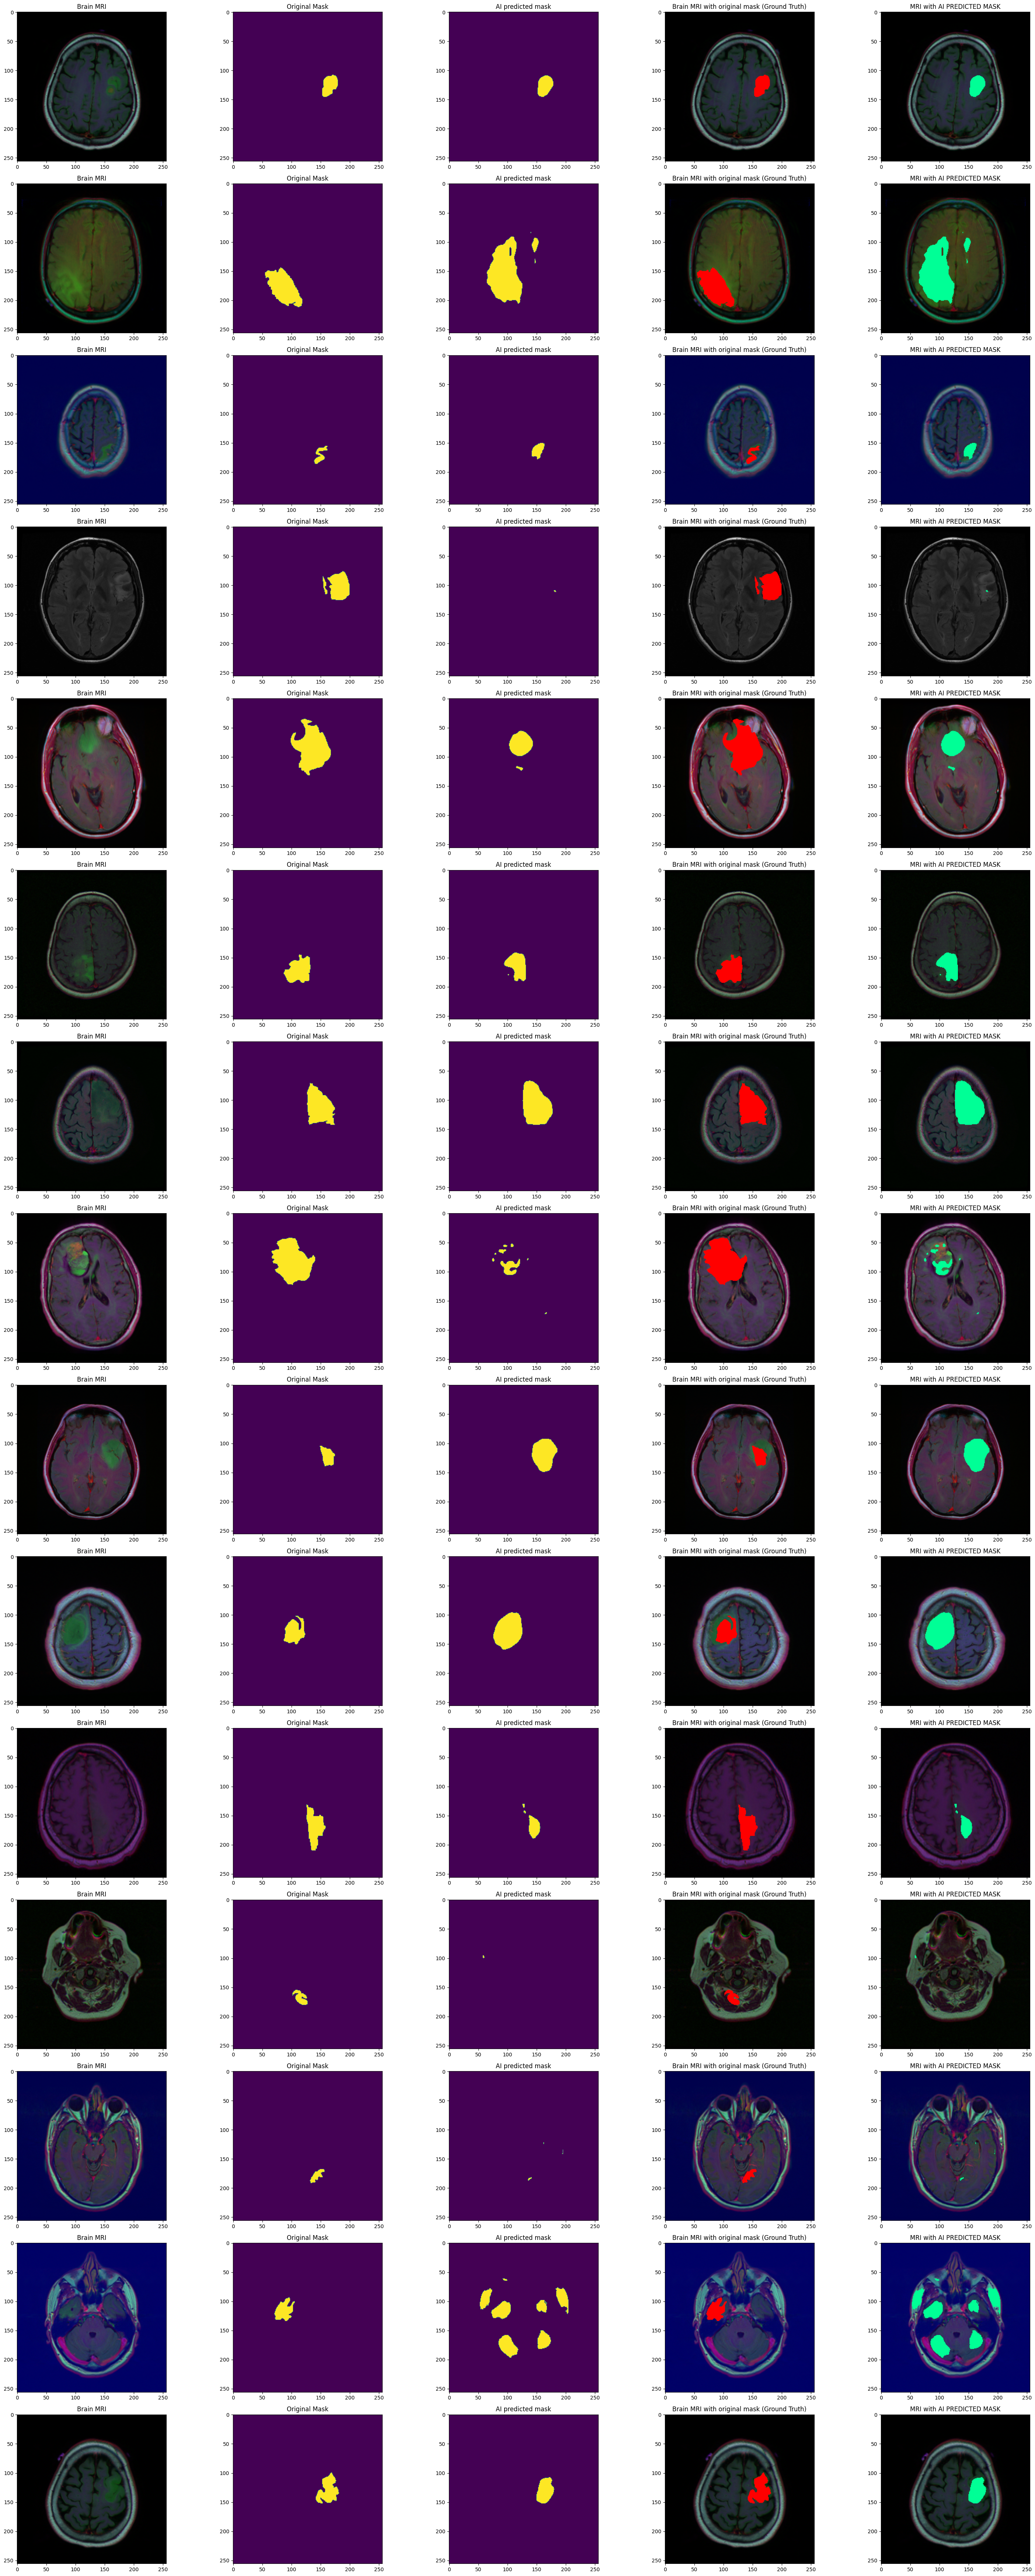

In [14]:
#visualizing prediction
count = 0
fig, axs = plt.subplots(15,5, figsize=(30,70))

for i in range(len(df_pred)):
    if df_pred.has_mask[i]==1 and count<15:
        #read mri images
        img = io.imread(df_pred.image_path[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[count][0].imshow(img)
        axs[count][0].title.set_text('Brain MRI')
        
        #read original mask
        mask = io.imread(df_pred.mask_path[i])
        axs[count][1].imshow(mask)
        axs[count][1].title.set_text('Original Mask')
        
        #read predicted mask
        pred = np.array(df_pred.predicted_mask[i]).squeeze().round()
        axs[count][2].imshow(pred)
        axs[count][2].title.set_text('AI predicted mask')
        
        #overlay original mask with MRI
        img[mask==255] = (255,0,0)
        axs[count][3].imshow(img)
        axs[count][3].title.set_text('Brain MRI with original mask (Ground Truth)')
        
        #overlay predicted mask and MRI
        img_ = io.imread(df_pred.image_path[i])
        img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
        img_[pred==1] = (0,255,150)
        axs[count][4].imshow(img_)
        axs[count][4].title.set_text('MRI with AI PREDICTED MASK')
        
        count +=1
    if (count==20):
        break

fig.tight_layout()

# Explanation:
***
1. **Visualization Setup:**
   * `fig, axs = plt.subplots(15, 5, figsize=(30, 70)):` This line sets up a grid of subplots for visualizing the original brain MRI, original mask, AI-predicted mask, brain MRI with original mask (ground truth), and brain MRI with AI-predicted mask. There are 15 rows (representing 15 images) and 5 columns (each column represents a different visualization).
2. **Visualization Loop:**
   * The code iterates through the rows of the `df_pred` DataFrame.
   * For each row where `has_mask` is 1 (indicating the presence of a tumor) and `count` is less than 15 (to limit the visualization to 15 examples):
      * The original brain MRI is displayed in the first column.
      * The original mask (ground truth) is displayed in the second column.
      * The AI-predicted mask is displayed in the third column.
      * The brain MRI with the original mask overlaid is displayed in the fourth column.
      * The brain MRI with the AI-predicted mask overlaid is displayed in the fifth column.
      * The `count` variable keeps track of the number of visualized examples, and the loop breaks when `count` reaches 15.
3. **Visualization Display:**
   * `fig.tight_layout():` This line ensures that the subplots are properly arranged within the figure.


The visualization provides a side-by-side comparison of the original MRI images, original masks, AI-predicted masks, and the overlaid results, allowing for a qualitative assessment of the model's performance. It helps in understanding how well the AI model is able to detect tumors in the brain MRI images and how closely its predictions align with the ground truth masks.ound truth masks.